# Türkiye Otomotiv Satış Adet Tahmini

Bu notebook'ta adım adım:
1. Veri analizi yaptım
2. Time Series ile bağımsız değişkenleri tahmin edip kaydettim.
3. Çoklu doğrusal regresyon modeli kurup kaydettim
4. Haz'22 - Haz'23 dönemini tahmin ettim.


## 1. Gerekli Kütüphaneler


In [1]:
# Temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Time Series için
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Machine Learning için
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Ayarlar
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Kütüphaneler yüklendi")


✅ Kütüphaneler yüklendi


/Users/ecedalpolat/Desktop/linkteracasesolving/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2. Veri Yükleme ve İnceleme


In [2]:
# Veriyi yükle
df = pd.read_excel('data/raw/Veri-Seti.xlsx')
print(f"Veri şekli: {df.shape}")
print(f"Sütunlar: {df.columns.tolist()}")
df.head()


Veri şekli: (162, 6)
Sütunlar: ['Date', 'Otomotiv Satis', 'OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']


,Date,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok
0,2010-01-01,20095.0,37.0,13.1820,2.107385,341244.126
1,2010-02-01,31172.0,37.0,13.2725,2.073890,351940.949
2,2010-03-01,51769.0,37.0,12.7275,2.085522,361307.320
3,2010-04-01,54946.0,37.0,12.0120,2.009010,373575.340
4,2010-05-01,59377.0,37.0,11.7400,1.948870,387708.051


In [3]:
# Tarih formatını düzenle ve eksik değerleri incele
df['Date'] = pd.to_datetime(df['Date'])

print(f"Tarih aralığı: {df['Date'].min()} - {df['Date'].max()}")
print(f"Toplam ay sayısı: {len(df)}")

print("\n=== EKSİK DEĞERLER ===")
missing_info = df.isnull().sum()
missing_pct = (missing_info / len(df)) * 100
missing_df = pd.DataFrame({'Eksik_Sayı': missing_info, 'Eksik_%': missing_pct})
print(missing_df)


Tarih aralığı: 2010-01-01 00:00:00 - 2023-06-01 00:00:00
Toplam ay sayısı: 162

=== EKSİK DEĞERLER ===
                Eksik_Sayı   Eksik_%
Date                     0  0.000000
Otomotiv Satis          13  8.024691
OTV Orani               13  8.024691
Faiz                    13  8.024691
EUR/TL                  13  8.024691
Kredi Stok              13  8.024691


## 3. Time Series Analizi 

**Time Series (Zaman Serisi)**
- Zamana göre sıralanmış veri noktaları
- Trend, mevsimsellik, döngü ve rastgele bileşenler içerir
- Geçmiş verilerden gelecek tahminleri yapar

**ARIMA Modeli**
- **AR (AutoRegressive)**: Geçmiş değerlerin bugünkü değeri etkilemesi
- **I (Integrated)**: Veriyi durağan hale getirmek için fark alma
- **MA (Moving Average)**: Geçmiş hataların bugünkü değeri etkilemesi

**ARIMA(p,d,q) Parametreleri:**
- **p**: AR parametresi (kaç geçmiş değer kullanılacak)
- **d**: Fark alma sayısı (durağanlık için)
- **q**: MA parametresi (kaç geçmiş hata kullanılacak)


Tam veri sayısı: 149
Son tam veri tarihi: 2022-05-01 00:00:00


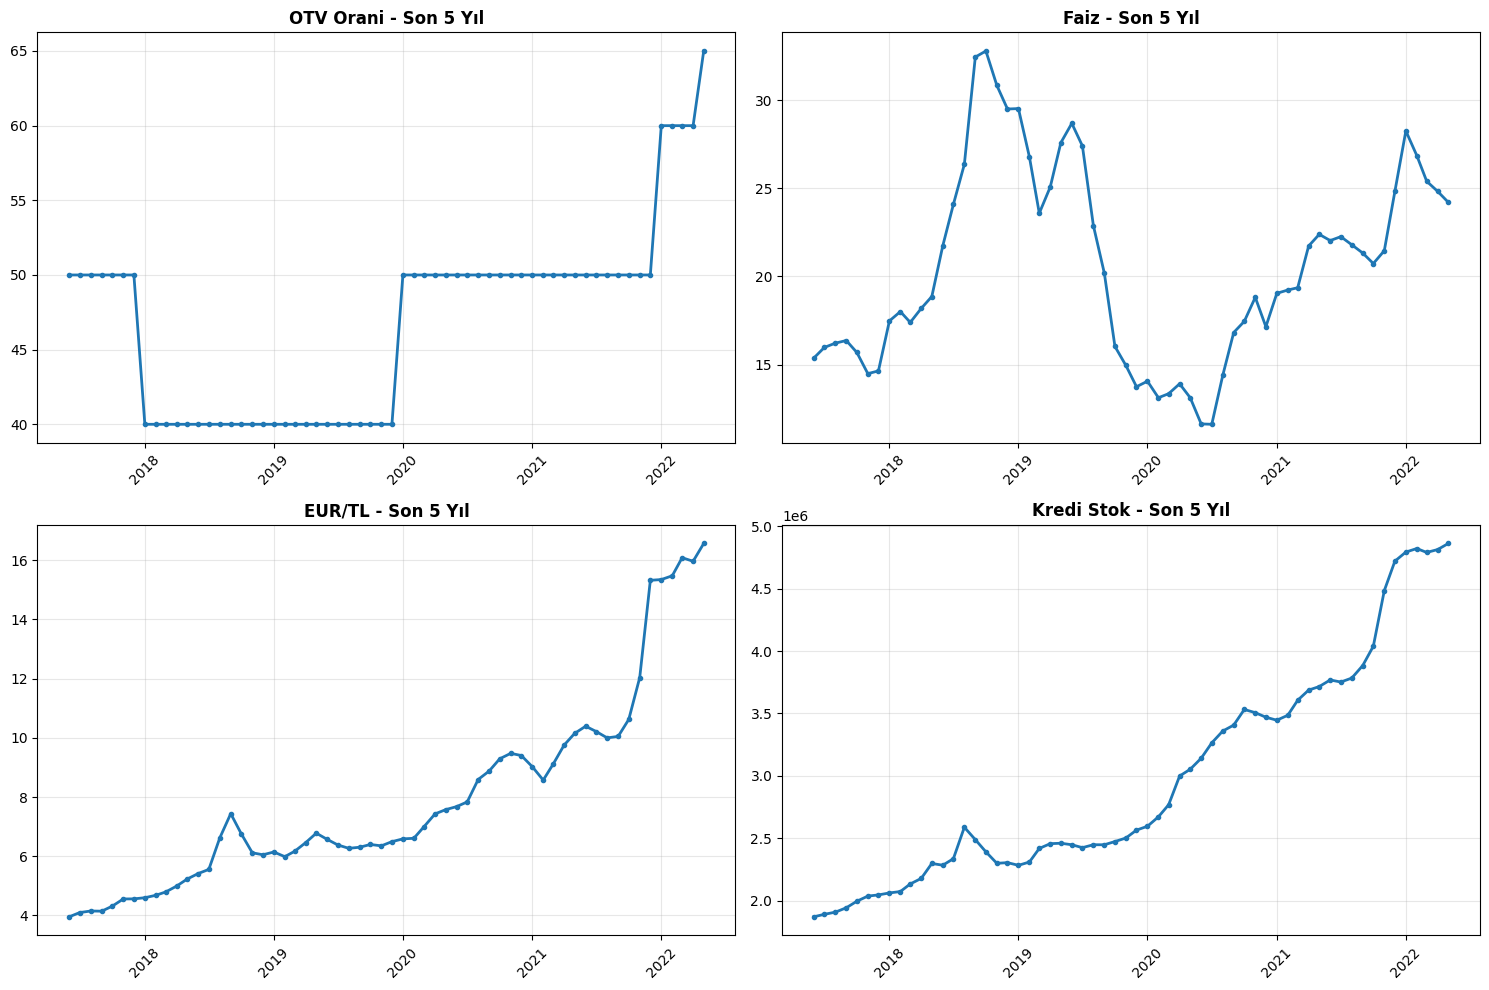

🔍 Grafiklere bakarak:
- Hangi değişkenler trend gösteriyor?
- Hangileri dalgalı/volatil?
- Mevsimsellik var mı?


In [4]:
# Önce veriyi görselleştirerek trend ve pattern'leri anlayalım
complete_data = df.dropna().copy()  # Tam verileri al
complete_data.set_index('Date', inplace=True)

print(f"Tam veri sayısı: {len(complete_data)}")
print(f"Son tam veri tarihi: {complete_data.index.max()}")

# Bağımsız değişkenleri görselleştir
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
independent_vars = ['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']

for i, var in enumerate(independent_vars):
    row = i // 2
    col = i % 2
    
    # Son 60 ay veriyi çiz (daha net görmek için)
    recent_data = complete_data[var][-60:]
    axes[row, col].plot(recent_data.index, recent_data.values, linewidth=2, marker='o', markersize=3)
    axes[row, col].set_title(f'{var} - Son 5 Yıl', fontweight='bold', fontsize=12)
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("🔍 Grafiklere bakarak:")
print("- Hangi değişkenler trend gösteriyor?")
print("- Hangileri dalgalı/volatil?") 
print("- Mevsimsellik var mı?")


### 3.1 Durağanlık Testi (Stationarity Test) 

**Durağanlık nedir?**
- Ortalama zamanla değişmez
- Varyans zamanla değişmez  
- Otokorelasyon sadece zaman farkına bağlı

**Neden önemli?**
- ARIMA modeli durağan veri gerektirir
- Durağan değilse tahminler yanıltıcı olur

**ADF Testi:**
- H0: Seri durağan DEĞİL (unit root var)
- H1: Seri durağan (unit root yok)
- p < 0.05 ise H0 red → durağan
- p >= 0.05 ise durağan değil → fark almalıyız


In [5]:
def check_stationarity_detailed(series, series_name):
    """
    Detaylı durağanlık testi ve açıklama
    """
    print(f"\n{'='*50}")
    print(f" {series_name} DURağanlık ANALİZİ")
    print(f"{'='*50}")
    
    # ADF testi
    adf_result = adfuller(series.dropna())
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    
    print(f"ADF İstatistiği: {adf_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Kritik Değerler:")
    for key, value in critical_values.items():
        print(f"  {key}: {value:.4f}")
    
    # Karar verme
    print(f"\n KARAR:")
    if p_value < 0.05:
        print(f" {series_name} DURağAN (p={p_value:.4f} < 0.05)")
        print("   → ARIMA modelinde d=0 kullanabiliriz")
        is_stationary = True
    else:
        print(f" {series_name} DURAĞAN DEĞİL (p={p_value:.4f} >= 0.05)")
        print("   → Fark almamız gerekiyor (d=1 veya d=2)")
        is_stationary = False
    
    # Serideki trend kontrolü
    diff_1 = series.diff().dropna()
    mean_original = series.mean()
    mean_diff = diff_1.mean()
    
    print(f"\n TRENDLERİN KARŞILAŞTIRILMASI:")
    print(f"Orijinal serinin ortalaması: {mean_original:.2f}")
    print(f"1. farkın ortalaması: {mean_diff:.2f}")
    
    return is_stationary, adf_stat, p_value

# Her değişken için durağanlık testi
stationarity_results = {}

for var in independent_vars:
    is_stationary, adf_stat, p_value = check_stationarity_detailed(complete_data[var], var)
    stationarity_results[var] = {
        'is_stationary': is_stationary,
        'adf_stat': adf_stat,
        'p_value': p_value
    }



 OTV Orani DURağanlık ANALİZİ
ADF İstatistiği: 0.1509
p-value: 0.9694
Kritik Değerler:
  1%: -3.4753
  5%: -2.8813
  10%: -2.5773

 KARAR:
 OTV Orani DURAĞAN DEĞİL (p=0.9694 >= 0.05)
   → Fark almamız gerekiyor (d=1 veya d=2)

 TRENDLERİN KARŞILAŞTIRILMASI:
Orijinal serinin ortalaması: 43.70
1. farkın ortalaması: 0.19

 Faiz DURağanlık ANALİZİ
ADF İstatistiği: -1.1700
p-value: 0.6864
Kritik Değerler:
  1%: -3.4797
  5%: -2.8832
  10%: -2.5783

 KARAR:
 Faiz DURAĞAN DEĞİL (p=0.6864 >= 0.05)
   → Fark almamız gerekiyor (d=1 veya d=2)

 TRENDLERİN KARŞILAŞTIRILMASI:
Orijinal serinin ortalaması: 16.03
1. farkın ortalaması: 0.07

 EUR/TL DURağanlık ANALİZİ
ADF İstatistiği: 3.7223
p-value: 1.0000
Kritik Değerler:
  1%: -3.4786
  5%: -2.8827
  10%: -2.5781

 KARAR:
 EUR/TL DURAĞAN DEĞİL (p=1.0000 >= 0.05)
   → Fark almamız gerekiyor (d=1 veya d=2)

 TRENDLERİN KARŞILAŞTIRILMASI:
Orijinal serinin ortalaması: 4.81
1. farkın ortalaması: 0.10

 Kredi Stok DURağanlık ANALİZİ
ADF İstatistiği: 3.60

### 3.2 ARIMA Parametrelerini Anlama

Durağanlık testinden sonra  ARIMA parametrelerini inceledim

**ARIMA(p,d,q) Parametreleri Nasıl Seçilir?**

1. **d (Differencing)**: Durağanlık testinden
   - Durağan ise d=0
   - 1 kez fark alınca durağan ise d=1
   - 2 kez fark alınca durağan ise d=2

2. **p (AR)**: ACF/PACF grafiklerinden veya AIC ile
   - Kaç geçmiş değer kullanacağız?
   - PACF grafiğinde keskin düşüşten

3. **q (MA)**: ACF/PACF grafiklerinden veya AIC ile  
   - Kaç geçmiş hata kullanacağız?
   - ACF grafiğinde keskin düşüşten

**Auto ARIMA**: Bu parametreleri otomatik bulur!


In [6]:
def fit_arima_detailed(series, variable_name, periods=13):
    """
    ARIMA modelini detaylı açıklamalarla kur
    """
    print(f"\n {variable_name} için ARIMA MODELİ KURULUYOR...")
    print("="*60)
    
    try:
        # Auto ARIMA ile en iyi parametreleri bul
        print(" 1. Auto ARIMA ile optimal parametreler aranıyor...")
        print("   (Bu işlem farklı (p,d,q) kombinasyonlarını deniyor)")
        
        model = auto_arima(
            series,
            start_p=0, start_q=0,           # Başlangıç değerleri
            max_p=3, max_q=3,               # Maksimum değerler  
            d=None,                         # d'yi otomatik bul
            seasonal=False,                 # Mevsimsellik yok (şimdilik)
            stepwise=True,                  # Hızlı arama
            suppress_warnings=True,         # Uyarıları gizle
            error_action='ignore',          # Hataları atla
            trace=True                      # Arama sürecini göster
        )
        
        print(f"\n EN İYİ MODEL BULUNDU: ARIMA{model.order}")
        p, d, q = model.order
        print(f"   p={p} (AR): Son {p} değeri kullan")
        print(f"   d={d} (Diff): {d} kez fark al") 
        print(f"   q={q} (MA): Son {q} hatayı kullan")
        
        # Model özeti
        print(f"\n MODEL ÖZETİ:")
        print(f"   AIC: {model.aic():.2f} (düşük=iyi)")
        print(f"   BIC: {model.bic():.2f} (düşük=iyi)")
        
        # Tahmin yap
        print(f"\n {periods} DÖNEM TAHMİNİ YAPILIYOR...")
        forecast = model.predict(n_periods=periods)
        
        # Tahmin aralığı
        forecast_ci = model.predict(n_periods=periods, return_conf_int=True)
        forecast_values = forecast_ci[0]  # Tahmin değerleri
        confidence_intervals = forecast_ci[1]  # Güven aralıkları
        
        # Tarih indeksi oluştur
        last_date = series.index[-1]
        forecast_dates = pd.date_range(
            start=last_date + pd.DateOffset(months=1),
            periods=periods,
            freq='MS'
        )
        
        forecast_series = pd.Series(forecast_values, index=forecast_dates)
        
        print(f" {variable_name} tahmini tamamlandı!")
        print(f"   Tahmin aralığı: {forecast_dates[0].strftime('%Y-%m')} - {forecast_dates[-1].strftime('%Y-%m')}")
        
        return model, forecast_series, confidence_intervals
        
    except Exception as e:
        print(f" HATA: {e}")
        return None, None, None

# İlk örnek olarak bir değişkeni detaylı şekilde analiz edelim
print(" ÖRNEKte EUR/TL değişkenini detaylı analiz ettim")

model_eur, forecast_eur, ci_eur = fit_arima_detailed(complete_data['EUR/TL'], 'EUR/TL', periods=13)


 ÖRNEKte EUR/TL değişkenini detaylı analiz ettim

 EUR/TL için ARIMA MODELİ KURULUYOR...
 1. Auto ARIMA ile optimal parametreler aranıyor...
   (Bu işlem farklı (p,d,q) kombinasyonlarını deniyor)
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=153.627, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=147.471, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=112.719, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=151.644, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=112.893, Time=0.01 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.213 seconds

 EN İYİ MODEL BULUNDU: ARIMA(0, 2, 1)
   p=0 (AR): Son 0 değeri kullan
   d=2 (Diff): 2 kez fark al
   q=1 (MA): Son 1 hatayı kullan

 MODEL ÖZETİ:
   AIC: 112.72 (düşük=iyi)


### 3.3 Tüm Bağımsız Değişkenler için ARIMA

Tüm bağımsız değişkenler için ARIMA modellerini kurDUM. Her birinin farklı karakteristikleri olduğunu ELDE ETTİM.

**Beklentilerimiz:**
- **ÖTV Oranı**: Politika değişikliklerine bağlı, belki durağan
- **Faiz**: Ekonomik koşullara bağlı, volatil
- **EUR/TL**: Trend ve volatil
- **Kredi Stok**: Büyüme trendi


In [7]:
# Tüm bağımsız değişkenler için ARIMA modelleri 
def forecast_all_variables():
    """
    Tüm bağımsız değişkenler için ARIMA tahmini
    """
    arima_models = {}
    forecasting_results = {}
    
    for var in independent_vars:
        print(f"\n{'#'*60}")
        print(f" ŞİMDİ {var} ANALİZ EDİLİYOR")
        print(f"{'#'*60}")
        
        # Basit ARIMA
        try:
            model = auto_arima(
                complete_data[var],
                start_p=0, start_q=0,
                max_p=3, max_q=3,
                seasonal=False,
                stepwise=True,
                suppress_warnings=True,
                trace=False  # Hızlı geçsin
            )
            
            # Tahmin
            forecast = model.predict(n_periods=13)
            
            # Tarih indeksi
            last_date = complete_data.index[-1]
            forecast_dates = pd.date_range(
                start=last_date + pd.DateOffset(months=1),
                periods=13,
                freq='MS'
            )
            
            forecast_series = pd.Series(forecast, index=forecast_dates)
            
            # Kaydetme
            arima_models[var] = model
            forecasting_results[var] = forecast_series
            
            # Özet bilgi
            p, d, q = model.order
            print(f" {var}: ARIMA({p},{d},{q})")
            print(f"   AIC: {model.aic():.1f}")
            print(f"   İlk tahmin: {forecast[0]:.2f}")
            print(f"   Son tahmin: {forecast[-1]:.2f}")
            
            # Trend analizi
            trend = "Yükseliş" if forecast[-1] > forecast[0] else "Düşüş"
            change_pct = ((forecast[-1] - forecast[0]) / forecast[0]) * 100
            print(f"   13 aylık trend: {trend} (%{change_pct:.1f})")
            
        except Exception as e:
            print(f" {var} için model kurulamadı: {e}")
    
    return arima_models, forecasting_results

# Tüm modelleri kur
print(" TÜM BAĞIMSIZ DEĞİŞKENLER İÇİN ARIMA MODELLERİ KURULUYOR...")
arima_models, forecasting_results = forecast_all_variables()


 TÜM BAĞIMSIZ DEĞİŞKENLER İÇİN ARIMA MODELLERİ KURULUYOR...

############################################################
 ŞİMDİ OTV Orani ANALİZ EDİLİYOR
############################################################
 OTV Orani: ARIMA(0,1,0)
   AIC: 563.1
   İlk tahmin: 65.19
   Son tahmin: 67.46
   13 aylık trend: Yükseliş (%3.5)

############################################################
 ŞİMDİ Faiz ANALİZ EDİLİYOR
############################################################
 Faiz: ARIMA(0,1,1)
   AIC: 473.3
   İlk tahmin: 24.00
   Son tahmin: 24.00
   13 aylık trend: Düşüş (%0.0)

############################################################
 ŞİMDİ EUR/TL ANALİZ EDİLİYOR
############################################################
 EUR/TL: ARIMA(0,2,1)
   AIC: 112.7
   İlk tahmin: 16.96
   Son tahmin: 22.04
   13 aylık trend: Yükseliş (%29.9)

############################################################
 ŞİMDİ Kredi Stok ANALİZ EDİLİYOR
##############################################


 TÜM TAHMİN SONUÇLARI:
            OTV Orani  Faiz  EUR/TL  Kredi Stok
2022-06-01      65.19  24.0   16.96  4931165.53
2022-07-01      65.38  24.0   17.37  5012659.43
2022-08-01      65.57  24.0   17.78  5102468.75
2022-09-01      65.76  24.0   18.19  5197153.46
2022-10-01      65.95  24.0   18.61  5294428.78
2022-11-01      66.14  24.0   19.02  5392864.86
2022-12-01      66.32  24.0   19.44  5491629.17
2023-01-01      66.51  24.0   19.87  5590283.99
2023-02-01      66.70  24.0   20.30  5688637.37
2023-03-01      66.89  24.0   20.73  5786639.39
2023-04-01      67.08  24.0   21.16  5884314.02
2023-05-01      67.27  24.0   21.60  5981716.88
2023-06-01      67.46  24.0   22.04  6078911.00


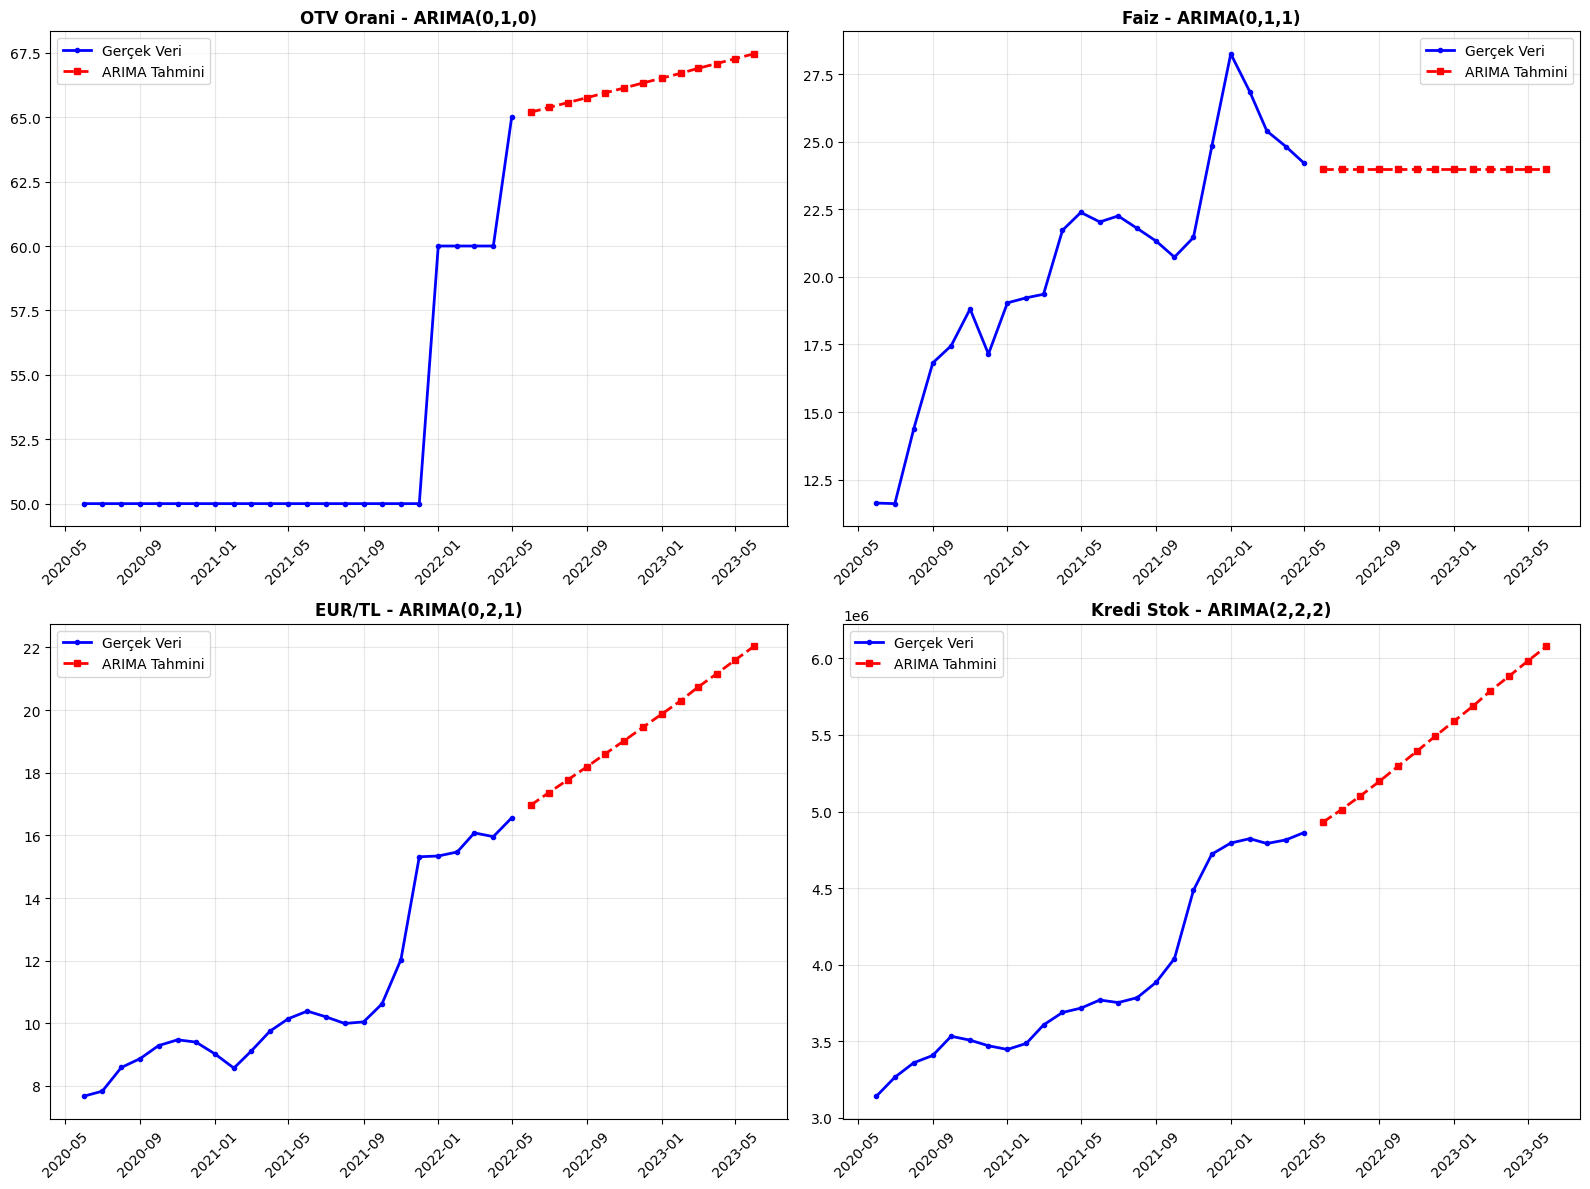


 MODEL KARŞILAŞTIRMASI:
  Değişken   ARIMA    AIC İlk_Tahmin Son_Tahmin Trend
 OTV Orani (0,1,0)  563.1      65.19      67.46    in
      Faiz (0,1,1)  473.3      24.00      24.00   out
    EUR/TL (0,2,1)  112.7      16.96      22.04    in
Kredi Stok (2,2,2) 3620.1 4931165.53 6078911.00    in


In [8]:
# Tahmin sonuçlarını görselleştirip analiz ettim
print("\n TÜM TAHMİN SONUÇLARI:")
print("="*60)

# Tahmin DataFrame'i oluştur  
forecast_df = pd.DataFrame(forecasting_results)
print(forecast_df.round(2))

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, var in enumerate(independent_vars):
    if var in forecasting_results:
        row = i // 2
        col = i % 2
        
        # Son 24 ay gerçek veri
        recent_data = complete_data[var][-24:]
        axes[row, col].plot(recent_data.index, recent_data.values, 
                           label='Gerçek Veri', linewidth=2, color='blue', marker='o', markersize=3)
        
        # Tahmin
        forecast = forecasting_results[var]
        axes[row, col].plot(forecast.index, forecast.values, 
                           label='ARIMA Tahmini', linewidth=2, color='red', linestyle='--', marker='s', markersize=4)
        
        # Model bilgisi başlıkta
        model = arima_models[var]
        p, d, q = model.order
        axes[row, col].set_title(f'{var} - ARIMA({p},{d},{q})', fontweight='bold', fontsize=12)
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Modellerin karşılaştırması
print("\n MODEL KARŞILAŞTIRMASI:")
print("="*60)
comparison_data = []
for var in independent_vars:
    if var in arima_models:
        model = arima_models[var]
        p, d, q = model.order
        forecast = forecasting_results[var]
        
        comparison_data.append({
            'Değişken': var,
            'ARIMA': f"({p},{d},{q})",
            'AIC': f"{model.aic():.1f}",
            'İlk_Tahmin': f"{forecast.iloc[0]:.2f}",
            'Son_Tahmin': f"{forecast.iloc[-1]:.2f}",
            'Trend': "in" if forecast.iloc[-1] > forecast.iloc[0] else "out"
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


### 3.4 Time Series Sonuçlarının Analizi

**ARIMA Parametrelerini Yorumlama:**

Yukarıdaki sonuçlara göre:

1. **d (Differencing) değeri** bize serinin durağanlığını söyler:
   - d=0: Seri zaten durağan
   - d=1: 1 kez fark alınca durağan (çoğu ekonomik seri)
   - d=2: 2 kez fark alınca durağan (çok trendy seriler)

2. **p (AR) değeri** geçmiş bağımlılığı gösterir:
   - p=0: Geçmiş değerler etkilemiyor
   - p=1: Sadece bir önceki ay etkiliyor
   - p=2,3: Daha uzun geçmiş hafıza

3. **q (MA) değeri** hata düzeltmeyi gösterir:
   - q=0: Geçmiş hatalar etkilemiyor
   - q=1,2: Geçmiş tahmin hatalarından öğreniyor

**Tahmin Güvenilirliği:**
- AIC değeri düşük olanlar daha güvenilir
- Trend tutarlı olanlar daha mantıklı


## 4. Basit Çoklu Doğrusal Regresyon

Time Series ile bağımsız değişkenleri tahmin ettim. Şimdi asıl amacım bu tahminleri kullanarak otomotiv satışlarını tahmin etmek.


In [9]:
# Tahmin verilerini kaydettim ve regresyon için hazırladım
forecast_df.to_csv('data/processed/independent_variables_forecast.csv')
print("Bağımsız değişken tahminleri kaydedildi")


# Tam veri setini birleştirdim (gerçek + tahmin)
full_data = df.copy()

# Eksik değerleri tahminlerle doldur
for var in independent_vars:
    if var in forecasting_results:
        forecast = forecasting_results[var]
        
        # Eksik dönemleri tespit edip doldurdum
        missing_mask = full_data[var].isnull()
        missing_dates = full_data.loc[missing_mask, 'Date']
        
        for date in missing_dates:
            if date in forecast.index:
                full_data.loc[full_data['Date'] == date, var] = forecast[date]

print(f"\n Doldurulmuş veri seti kontrol:")
print("Eksik değerler (bağımsız değişkenler):")
print(full_data[independent_vars].isnull().sum())

# Eğitim verisi (hedef değişkeni eksik olmayan)
train_data = full_data[full_data['Otomotiv Satis'].notna()].copy()
print(f"\nEğitim veri sayısı: {len(train_data)}")
print(f"Eğitim tarihi: {train_data['Date'].min().strftime('%Y-%m')} - {train_data['Date'].max().strftime('%Y-%m')}")

# Basit özellikler ekledim.
train_data['Month'] = pd.to_datetime(train_data['Date']).dt.month
train_data['Year'] = pd.to_datetime(train_data['Date']).dt.year

# Model için özellikler ekledim.
feature_columns = independent_vars + ['Month', 'Year']
print(f"\nKullanılacak özellikler: {feature_columns}")

X_train = train_data[feature_columns]
y_train = train_data['Otomotiv Satis']

print(f"X shape: {X_train.shape}, y shape: {y_train.shape}")
print(f"Eksik değer kontrolü - X: {X_train.isnull().sum().sum()}, y: {y_train.isnull().sum()}")


Bağımsız değişken tahminleri kaydedildi

 Doldurulmuş veri seti kontrol:
Eksik değerler (bağımsız değişkenler):
OTV Orani     0
Faiz          0
EUR/TL        0
Kredi Stok    0
dtype: int64

Eğitim veri sayısı: 149
Eğitim tarihi: 2010-01 - 2022-05

Kullanılacak özellikler: ['OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok', 'Month', 'Year']
X shape: (149, 6), y shape: (149,)
Eksik değer kontrolü - X: 0, y: 0


 REGRESYON MODELİ PERFORMANSI:
R² Score: 0.5183 (1'e yakın=iyi)
MAE: 14,549 adet
RMSE: 18,106 adet
MAPE: 25.16% (düşük=iyi)

 ÖZELLİK ÖNEMLİLİĞİ:
   Özellik      Katsayı
    EUR/TL -9166.423024
      Year -5880.402855
     Month  3753.915450
 OTV Orani  1765.527891
      Faiz -1188.055748
Kredi Stok     0.036277


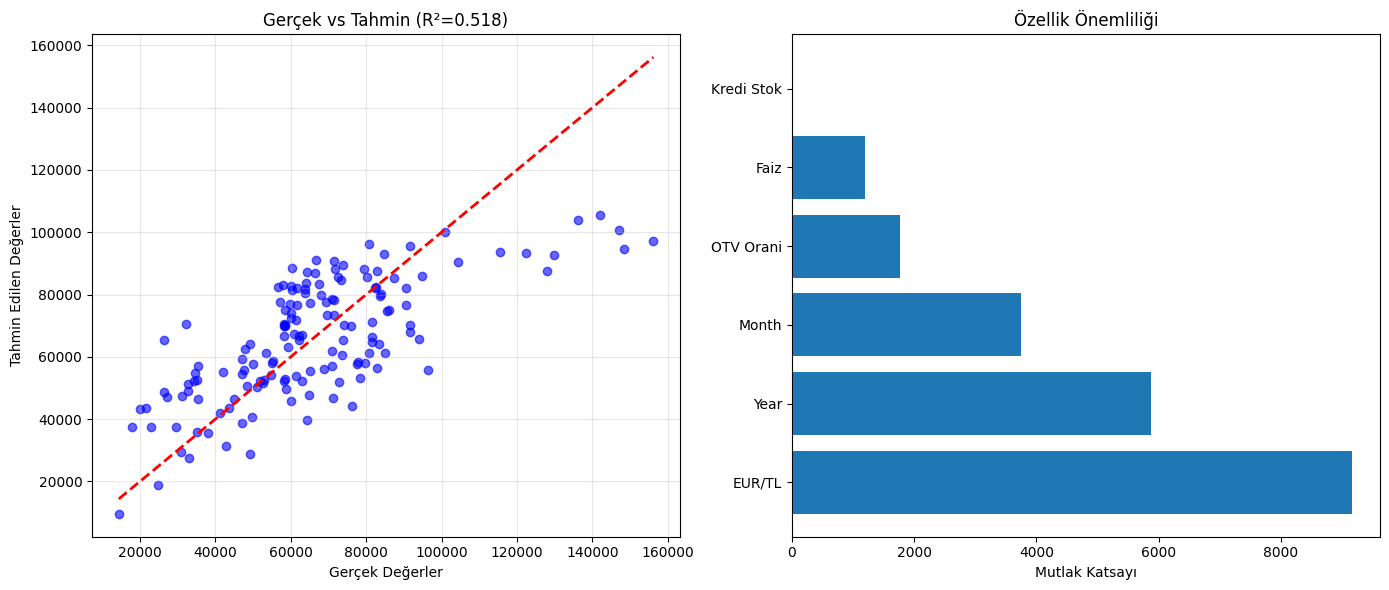

 Regresyon modeli eğitimi tamamlandı!


In [10]:
# Basit doğrusal regresyon modeli kurulan alan
model = LinearRegression()
model.fit(X_train, y_train)

# Model performansı
y_pred_train = model.predict(X_train)

r2 = r2_score(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

print(" REGRESYON MODELİ PERFORMANSI:")
print(f"R² Score: {r2:.4f} (1'e yakın=iyi)")
print(f"MAE: {mae:,.0f} adet")
print(f"RMSE: {rmse:,.0f} adet") 
print(f"MAPE: {mape:.2f}% (düşük=iyi)")

# Özellik önemliliklerini gösterdim
feature_importance = pd.DataFrame({
    'Özellik': feature_columns,
    'Katsayı': model.coef_,
    'Mutlak_Katsayı': np.abs(model.coef_)
}).sort_values('Mutlak_Katsayı', ascending=False)

print(f"\n ÖZELLİK ÖNEMLİLİĞİ:")
print(feature_importance[['Özellik', 'Katsayı']].to_string(index=False))

# Görselleştirme
plt.figure(figsize=(14, 6))

# Sol: Gerçek vs Tahmin
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title(f'Gerçek vs Tahmin (R²={r2:.3f})')
plt.grid(True, alpha=0.3)

# Sağ: Özellik önemliliği
plt.subplot(1, 2, 2)
plt.barh(feature_importance['Özellik'], feature_importance['Mutlak_Katsayı'])
plt.title('Özellik Önemliliği')
plt.xlabel('Mutlak Katsayı')

plt.tight_layout()
plt.show()

print(" Regresyon modeli eğitimi tamamlandı!")


## 5. Final Tahmin: Haz'22 - Haz'23

Eğittiğim regresyon modelini kullanarak eksik dönemleri (Haz'22 - Haz'23) tahmin ettim.


In [11]:
# Tahmin edilecek dönemleri hazırladığım alan
prediction_data = full_data[full_data['Otomotiv Satis'].isna()].copy()

print(f"Tahmin edilecek dönem sayısı: {len(prediction_data)}")
print(f"Tahmin dönemi: {prediction_data['Date'].min().strftime('%Y-%m')} - {prediction_data['Date'].max().strftime('%Y-%m')}")

if len(prediction_data) > 0:
    # Aynı özellikleri ekle
    prediction_data['Month'] = pd.to_datetime(prediction_data['Date']).dt.month
    prediction_data['Year'] = pd.to_datetime(prediction_data['Date']).dt.year
    
    # Özellik matrisi
    X_predict = prediction_data[feature_columns]
    
    print(f"Tahmin veri şekli: {X_predict.shape}")
    print(f"Eksik değer: {X_predict.isnull().sum().sum()}")
    
    # TAHMİN YAP!
    y_pred_future = model.predict(X_predict)
    
    # Sonuçları düzenle
    results = pd.DataFrame({
        'Tarih': prediction_data['Date'].dt.strftime('%Y-%m'),
        'Tahmin_Edilen_Satis': np.round(y_pred_future, 0).astype(int)
    })
    
    print("\n OTOMOTIV SATIŞ TAHMİNLERİ (Haz'22 - Haz'23):")
    print("="*50)
    print(results.to_string(index=False))
    
    # İstatistikler
    total_predicted = y_pred_future.sum()
    avg_monthly = y_pred_future.mean()
    
    print(f"\n TAHMİN ÖZETİ:")
    print(f"Toplam 13 aylık satış: {total_predicted:,.0f} adet")
    print(f"Aylık ortalama: {avg_monthly:,.0f} adet")
    
    # Geçmiş ortalamayla karşılaştır
    historical_avg = y_train.mean()
    change_pct = ((avg_monthly - historical_avg) / historical_avg) * 100
    print(f"Geçmiş aylık ortalama: {historical_avg:,.0f} adet")
    print(f"Değişim: {change_pct:+.1f}%")
    
    # Kaydet
    results.to_csv('data/processed/automotive_sales_predictions.csv', index=False)
    print(f"\n Tahminler kaydedildi")
    
else:
    print(" Tahmin edilecek dönem bulunamadı!")


Tahmin edilecek dönem sayısı: 13
Tahmin dönemi: 2022-06 - 2023-06
Tahmin veri şekli: (13, 6)
Eksik değer: 0

 OTOMOTIV SATIŞ TAHMİNLERİ (Haz'22 - Haz'23):
  Tarih  Tahmin_Edilen_Satis
2022-06                58631
2022-07                61953
2022-08                65549
2022-09                69295
2022-10                73106
2022-11                76932
2022-12                80742
2023-01                33593
2023-02                37333
2023-03                41032
2023-04                44691
2023-05                48313
2023-06                51900

 TAHMİN ÖZETİ:
Toplam 13 aylık satış: 743,071 adet
Aylık ortalama: 57,159 adet
Geçmiş aylık ortalama: 65,903 adet
Değişim: -13.3%

 Tahminler kaydedildi


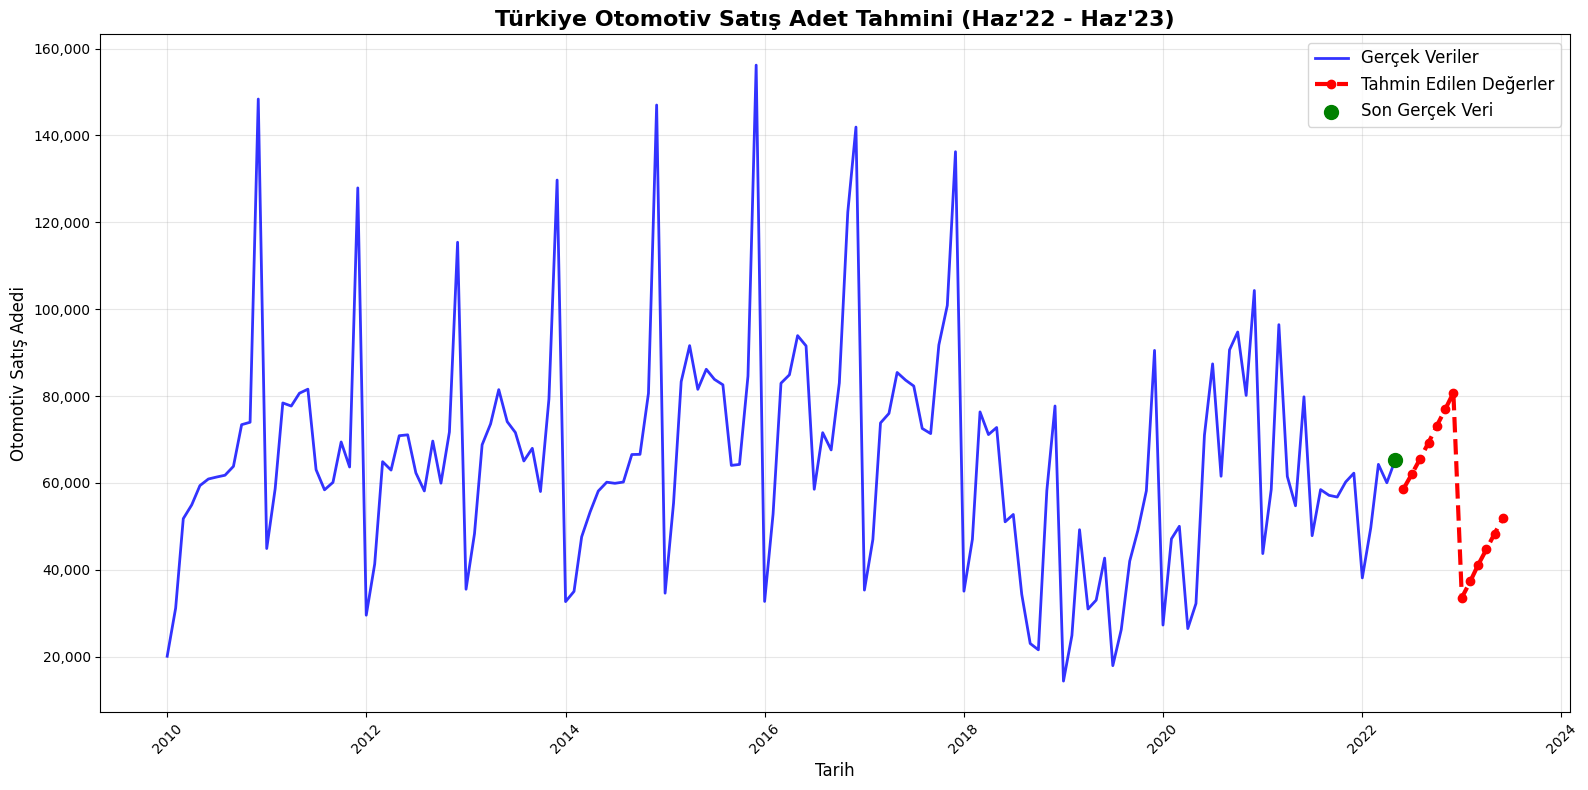


 ANALİZ TAMAMLANDI!

KULLANDIĞIMIZ YÖNTEM:
1. Time Series (ARIMA) → Bağımsız değişken tahminleri
2. Multiple Linear Regression → Hedef değişken tahmini

MODEL PERFORMANSI:
- R² Score: 0.518
- MAPE: 25.2%
- MAE: 14,549 adet
- RMSE: 18,106 adet

SONUÇ:
- 13 aylık toplam: 743,071 adet
- Aylık ortalama: 57,159 adet
- Geçmiş ortalamaya göre: -6.2%



In [18]:
# Final görselleştirme
plt.figure(figsize=(16, 8))

# Geçmiş veriler (eğitim)
plt.plot(train_data['Date'], train_data['Otomotiv Satis'], 
         label='Gerçek Veriler', linewidth=2, color='blue', alpha=0.8)

# Tahminler
if len(prediction_data) > 0:
    plt.plot(prediction_data['Date'], y_pred_future, 
             label='Tahmin Edilen Değerler', linewidth=3, color='red', 
             linestyle='--', marker='o', markersize=6)

# Son gerçek veri noktası
last_real = train_data.iloc[-1]
plt.scatter(last_real['Date'], last_real['Otomotiv Satis'], 
           color='green', s=100, zorder=5, label='Son Gerçek Veri')

plt.title('Türkiye Otomotiv Satış Adet Tahmini (Haz\'22 - Haz\'23)', 
         size=16, fontweight='bold')
plt.xlabel('Tarih', size=12)
plt.ylabel('Otomotiv Satış Adedi', size=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Y ekseni formatı
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

print(f"""
 ANALİZ TAMAMLANDI!

KULLANDIĞIMIZ YÖNTEM:
1. Time Series (ARIMA) → Bağımsız değişken tahminleri
2. Multiple Linear Regression → Hedef değişken tahmini

MODEL PERFORMANSI:
- R² Score: {r2:.3f}
- MAPE: {mape:.1f}%
- MAE: {mae:,.0f} adet
- RMSE: {rmse:,.0f} adet

SONUÇ:
- 13 aylık toplam: {total_predicted:,.0f} adet
- Aylık ortalama: {avg_monthly:,.0f} adet
- Geçmiş ortalamaya göre: {change_pct:+.1f}%
""")


## 6. Modeli Kaydetme ve API Hazırlığı

Modeli kaydettim ve REST API olarak servis etmeye hazırladım.


In [13]:
# Modeli ve gerekli bilgileri kaydettiğimiz librarys
import joblib
import os

# Model klasörü oluşturarak erişimini sağladım
os.makedirs('models', exist_ok=True)

# Model verilerini hazırla
model_data = {
    'regression_model': model,              # Regresyon modeli
    'arima_models': arima_models,          # ARIMA modelleri
    'feature_columns': feature_columns,     # Kullanılan özellikler
    'independent_vars': independent_vars,   # Bağımsız değişkenler
    'model_performance': {                  # Model performansı
        'r2': r2,
        'mae': mae,
        'rmse': rmse, 
        'mape': mape
    }
}

# Kaydet
model_path = 'models/automotive_prediction_model.pkl'
joblib.dump(model_data, model_path)

print(f" Model kaydedildi: {model_path}")
print(f"Dosya boyutu: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")

# Model bilgilerini göster
print(f"""
KAYDEDILEN MODEL BİLGİLERİ:
- Regresyon modeli: LinearRegression
- ARIMA modelleri: {len(arima_models)} adet
- Özellik sayısı: {len(feature_columns)}
- Model performansı: R²={r2:.3f}, MAPE={mape:.1f}%
""")


 Model kaydedildi: models/automotive_prediction_model.pkl
Dosya boyutu: 2.40 MB

KAYDEDILEN MODEL BİLGİLERİ:
- Regresyon modeli: LinearRegression
- ARIMA modelleri: 4 adet
- Özellik sayısı: 6
- Model performansı: R²=0.518, MAPE=25.2%



## 8. API Testleri 

Flask gereksinimlerini yükleyip, API'yi test ettik.


In [14]:
# API test fonksiyonları oluştur (Flask olmadan test etmek için)
def test_prediction_function(date, values=None):
    """
    API'nin predict fonksiyonunu notebook içinde test etmek için oluşturulan alan
    """
    try:
        # Modeli yükle (zaten yüklü ama kontrol edelim)
        loaded_data = joblib.load('models/automotive_prediction_model.pkl')
        reg_model = loaded_data['regression_model']
        features = loaded_data['feature_columns']
        indep_vars = loaded_data['independent_vars']
        
        # Tarih işle
        predict_date = pd.to_datetime(date)
        
        # Bağımsız değişkenleri hazırla
        if values is None:
            # Varsayılan/ortalama değerler kullan
            values = {}
            for var in indep_vars:
                if var in forecasting_results:
                    # ARIMA tahmininden al
                    forecast_data = forecasting_results[var]
                    # En yakın tarihi bul
                    closest_date = min(forecast_data.index, key=lambda x: abs(x - predict_date))
                    values[var] = forecast_data[closest_date]
                else:
                    # Varsayılan değerler
                    defaults = {
                        'OTV Orani': 65.0,
                        'Faiz': 24.0,
                        'EUR/TL': 17.0,
                        'Kredi Stok': 5000000
                    }
                    values[var] = defaults.get(var, 0)
        
        # Özellik vektörü
        feature_dict = {}
        for var in indep_vars:
            feature_dict[var] = values[var]
        feature_dict['Month'] = predict_date.month
        feature_dict['Year'] = predict_date.year
        
        # Tahmin
        X_pred = pd.DataFrame([feature_dict])[features]
        prediction = reg_model.predict(X_pred)[0]
        
        return {
            'success': True,
            'date': predict_date.strftime('%Y-%m'),
            'predicted_sales': round(prediction, 0),
            'inputs': values,
            'features': feature_dict
        }
        
    except Exception as e:
        return {'success': False, 'error': str(e)}

# Test senaryoları
test_scenarios = [
    {
        'name': 'Haz 2022 - ARIMA Tahminleriyle',
        'date': '2022-06-01',
        'values': None  # ARIMA tahminlerini kullan
    },
    {
        'name': 'Oca 2023 - Manuel Değerlerle',
        'date': '2023-01-01',
        'values': {
            'OTV Orani': 70.0,
            'Faiz': 25.0,
            'EUR/TL': 18.0,
            'Kredi Stok': 5200000
        }
    },
    {
        'name': 'Haz 2023 - Optimistik Senaryo',
        'date': '2023-06-01',
        'values': {
            'OTV Orani': 60.0,  # Düşük ÖTV
            'Faiz': 20.0,       # Düşük faiz
            'EUR/TL': 16.0,     # Güçlü TL
            'Kredi Stok': 6000000  # Yüksek kredi
        }
    }
]

print(" API FONKSİYON TESTLERİ:")
print("="*50)

for scenario in test_scenarios:
    print(f"\n {scenario['name']}:")
    result = test_prediction_function(scenario['date'], scenario['values'])
    
    if result['success']:
        print(f"    Tarih: {result['date']}")
        print(f"   Tahmin: {result['predicted_sales']:,.0f} adet")
        print(f"    Girdi değerleri:")
        for var, val in result['inputs'].items():
            print(f"      {var}: {val:.2f}")
    else:
        print(f"    Hata: {result['error']}")
        
print(f"\nFonksiyon testleri tamamlandı!")


 API FONKSİYON TESTLERİ:

 Haz 2022 - ARIMA Tahminleriyle:
    Tarih: 2022-06
   Tahmin: 58,631 adet
    Girdi değerleri:
      OTV Orani: 65.19
      Faiz: 24.00
      EUR/TL: 16.96
      Kredi Stok: 4931165.53

 Oca 2023 - Manuel Değerlerle:
    Tarih: 2023-01
   Tahmin: 41,539 adet
    Girdi değerleri:
      OTV Orani: 70.00
      Faiz: 25.00
      EUR/TL: 18.00
      Kredi Stok: 5200000.00

 Haz 2023 - Optimistik Senaryo:
    Tarih: 2023-06
   Tahmin: 95,949 adet
    Girdi değerleri:
      OTV Orani: 60.00
      Faiz: 20.00
      EUR/TL: 16.00
      Kredi Stok: 6000000.00

Fonksiyon testleri tamamlandı!


## 9. Senaryol Analizi ve Karşılaştırma

Kaydettiğim model farklı ekonomik senaryolar altında otomotiv satışlarının nasıl değişeceğini analiz ettim.


 SENARYO ANALİZİ (Ocak 2023)
     Senaryo Tahmin_Satış   ÖTV  Faiz EUR/TL Kredi(M)
Mevcut_Durum       35,811 65.0% 24.0%   17.0      5.0
  Optimistik       79,894 55.0% 18.0%   15.0      6.0
  Pesimistik      -17,439 75.0% 30.0%   20.0      4.0
Gerçek_ARIMA       33,593 66.5% 24.0%   19.9      5.6


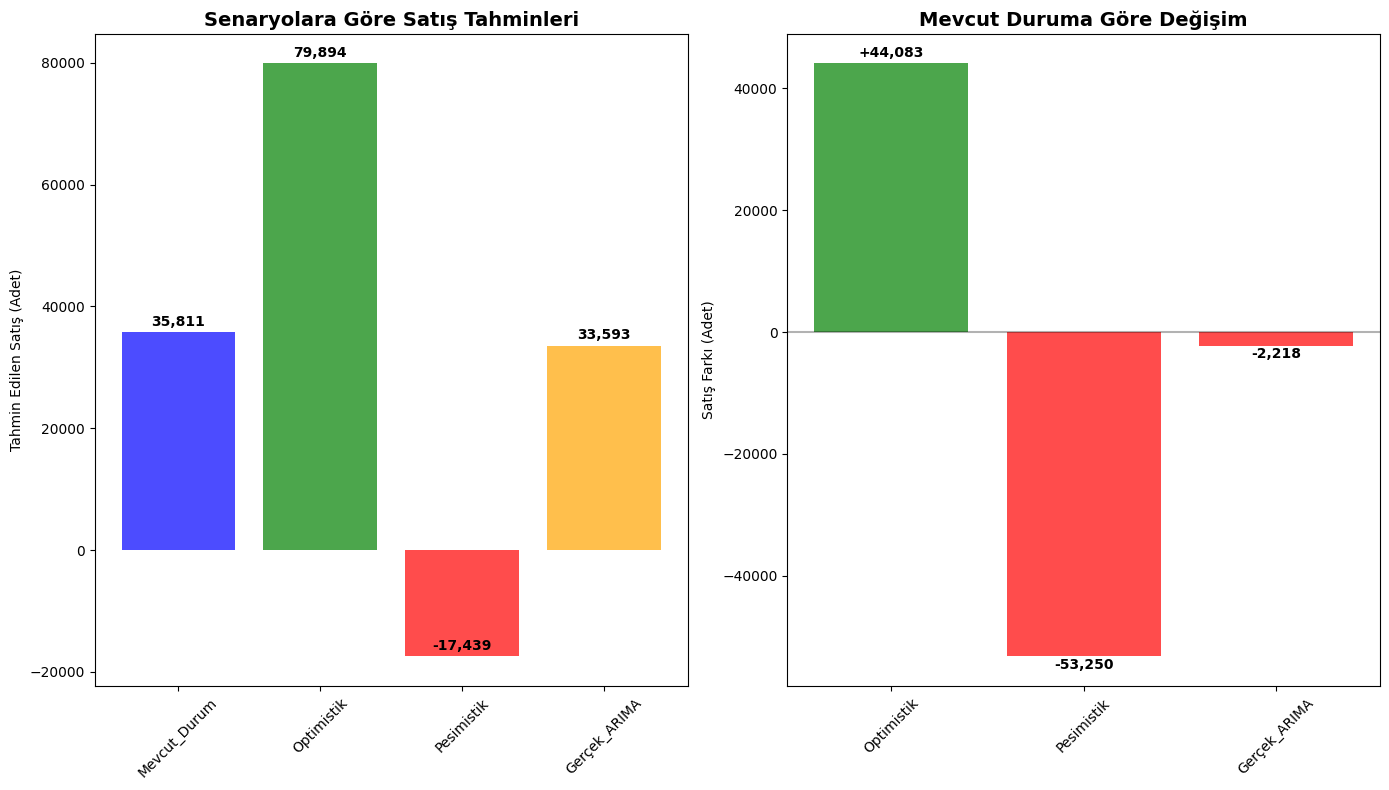


 ETKİ ANALİZİ:
Mevcut Durum (Baz): 35,811 adet
Optimistik: +44,083 adet (+123.1%) in
Pesimistik: -53,250 adet (-148.7%) out
Gerçek_ARIMA: -2,218 adet (-6.2%) out


In [15]:
# Farklı senaryolar için karşılaştırmalı analiz
def scenario_analysis():
    """
    Farklı ekonomik senaryoları karşılaştırdım
    """
    scenarios = {
        'Mevcut_Durum': {
            'OTV Orani': 65.0,
            'Faiz': 24.0,
            'EUR/TL': 17.0,
            'Kredi Stok': 5000000
        },
        'Optimistik': {
            'OTV Orani': 55.0,  # ÖTV indirimi
            'Faiz': 18.0,       # Faiz düşüşü
            'EUR/TL': 15.0,     # TL güçlenmesi
            'Kredi Stok': 6000000  # Kredi artışı
        },
        'Pesimistik': {
            'OTV Orani': 75.0,  # ÖTV artışı
            'Faiz': 30.0,       # Faiz artışı
            'EUR/TL': 20.0,     # TL zayıflaması
            'Kredi Stok': 4000000  # Kredi daralması
        },
        'Gerçek_ARIMA': None   # ARIMA tahminlerini kullanacağız
    }
    
    # Test tarihi
    test_date = '2023-01-01'
    
    results = []
    for scenario_name, values in scenarios.items():
        result = test_prediction_function(test_date, values)
        if result['success']:
            results.append({
                'Senaryo': scenario_name,
                'Tahmin': result['predicted_sales'],
                'Değerler': result['inputs']
            })
    
    return results

# Senaryo analizini çalıştır
print(" SENARYO ANALİZİ (Ocak 2023)")
print("="*60)

scenario_results = scenario_analysis()

# Sonuçları tablo halinde göster
comparison_df = pd.DataFrame([
    {
        'Senaryo': r['Senaryo'],
        'Tahmin_Satış': f"{r['Tahmin']:,.0f}",
        'ÖTV': f"{r['Değerler']['OTV Orani']:.1f}%",
        'Faiz': f"{r['Değerler']['Faiz']:.1f}%",
        'EUR/TL': f"{r['Değerler']['EUR/TL']:.1f}",
        'Kredi(M)': f"{r['Değerler']['Kredi Stok']/1000000:.1f}"
    } for r in scenario_results
])

print(comparison_df.to_string(index=False))

# Görselleştirme
plt.figure(figsize=(14, 8))

# Sol: Tahmin karşılaştırması
plt.subplot(1, 2, 1)
scenario_names = [r['Senaryo'] for r in scenario_results]
predictions = [r['Tahmin'] for r in scenario_results]
colors = ['blue', 'green', 'red', 'orange']

bars = plt.bar(scenario_names, predictions, color=colors, alpha=0.7)
plt.title('Senaryolara Göre Satış Tahminleri', fontweight='bold', fontsize=14)
plt.ylabel('Tahmin Edilen Satış (Adet)')
plt.xticks(rotation=45)

# Değerleri çubukların üstüne yaz
for bar, pred in zip(bars, predictions):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{pred:,.0f}', ha='center', fontweight='bold')

# Sağ: Değişken etkisi analizi
plt.subplot(1, 2, 2)
base_prediction = scenario_results[0]['Tahmin']  # Mevcut durum
effects = [(pred - base_prediction) for pred in predictions[1:]]
effect_names = scenario_names[1:]

colors_effect = ['green' if e > 0 else 'red' for e in effects]
bars2 = plt.bar(effect_names, effects, color=colors_effect, alpha=0.7)
plt.title('Mevcut Duruma Göre Değişim', fontweight='bold', fontsize=14)
plt.ylabel('Satış Farkı (Adet)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Değerleri çubukların üstüne/altına yaz
for bar, effect in zip(bars2, effects):
    y_pos = bar.get_height() + (1000 if effect > 0 else -2000)
    plt.text(bar.get_x() + bar.get_width()/2, y_pos,
             f'{effect:+,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Etki analizi
print(f"\n ETKİ ANALİZİ:")
base = scenario_results[0]['Tahmin']
print(f"Mevcut Durum (Baz): {base:,.0f} adet")

for i, result in enumerate(scenario_results[1:], 1):
    change = result['Tahmin'] - base
    change_pct = (change / base) * 100
    direction = "in" if change > 0 else "out"
    print(f"{result['Senaryo']}: {change:+,.0f} adet ({change_pct:+.1f}%) {direction}")


## 10. API Çalıştırma ve Gerçek Testler

Şimdi oluşturduğumuz API'yi gerçekten çalıştıralım ve curl/requests ile test edelim.


In [16]:
# API'yi başlatmak için gerekli komutları göster
print(" API BAŞLATMA TALİMATLARI:")
print("="*50)

print("""
1️ TERMINAL'DE API'Yİ BAŞLATIN:
   cd /Users/ecedalpolat/Desktop/linkteracasesolving
   python automotive_api.py

2️ YENİ TERMINAL'DE TEST YAPTIN:
   # Sağlık kontrolü
   curl http://localhost:8080/health
   
   # Model bilgileri
   curl http://localhost:8080/model/info
   
   # Tek tahmin
   curl -X POST http://localhost:8080/predict \\
        -H "Content-Type: application/json" \\
        -d '{"date": "2023-01-01"}'
   
   # Manuel değerlerle tahmin
   curl -X POST http://localhost:8080/predict \\
        -H "Content-Type: application/json" \\
        -d '{
          "date": "2023-01-01",
          "values": {
            "OTV Orani": 60.0,
            "Faiz": 20.0,
            "EUR/TL": 16.0,
            "Kredi Stok": 5500000
          }
        }'
   
   # Tarih aralığı tahmini
   curl -X POST http://localhost:8080/predict/range \\
        -H "Content-Type: application/json" \\
        -d '{
          "start_date": "2022-06-01",
          "end_date": "2023-06-01",
          "values": {
            "OTV Orani": 65.0,
            "Faiz": 24.0,
            "EUR/TL": 17.0,
            "Kredi Stok": 5000000
          }
        }'
""")

# Requests ile API test fonksiyonu oluştur
import requests
import json

def test_api_with_requests():
    """
    Requests kütüphanesi ile API'yi test et
    """
    base_url = "http://localhost:8080"
    
    tests = [
        {
            'name': 'Health Check',
            'method': 'GET',
            'url': f'{base_url}/health',
            'data': None
        },
        {
            'name': 'Model Info',
            'method': 'GET', 
            'url': f'{base_url}/model/info',
            'data': None
        },
        {
            'name': 'Single Prediction',
            'method': 'POST',
            'url': f'{base_url}/predict',
            'data': {
                "date": "2023-01-01",
                "values": {
                    "OTV Orani": 65.0,
                    "Faiz": 24.0,
                    "EUR/TL": 17.0,
                    "Kredi Stok": 5000000
                }
            }
        }
    ]
    
    print(f"\n🧪 REQUESTS İLE API TESTLERİ:")
    print("="*40)
    
    for test in tests:
        try:
            print(f"\n📋 {test['name']}:")
            
            if test['method'] == 'GET':
                response = requests.get(test['url'], timeout=5)
            else:
                response = requests.post(test['url'], 
                                       json=test['data'], 
                                       timeout=5)
            
            if response.status_code == 200:
                result = response.json()
                print(f"   ✅ Başarılı (200)")
                print(f"   📄 Yanıt: {json.dumps(result, indent=2, ensure_ascii=False)[:200]}...")
            else:
                print(f"   ❌ Hata ({response.status_code}): {response.text}")
                
        except requests.exceptions.ConnectionError:
            print(f"   🔌 Bağlantı hatası - API çalışmıyor olabilir")
        except Exception as e:
            print(f"   ❌ Hata: {e}")

# Not: Bu fonksiyon sadece API çalışırken çalışır
print(f"\n💡 NOT: API testleri için önce 'python automotive_api.py' komutunu çalıştırın!")
print(f"Sonra aşağıdaki fonksiyonu çağırabilirsiniz:")
print(f"test_api_with_requests()")


 API BAŞLATMA TALİMATLARI:

1️ TERMINAL'DE API'Yİ BAŞLATIN:
   cd /Users/ecedalpolat/Desktop/linkteracasesolving
   python automotive_api.py

2️ YENİ TERMINAL'DE TEST YAPTIN:
   # Sağlık kontrolü
   curl http://localhost:8080/health
   
   # Model bilgileri
   curl http://localhost:8080/model/info
   
   # Tek tahmin
   curl -X POST http://localhost:8080/predict \
        -H "Content-Type: application/json" \
        -d '{"date": "2023-01-01"}'
   
   # Manuel değerlerle tahmin
   curl -X POST http://localhost:8080/predict \
        -H "Content-Type: application/json" \
        -d '{
          "date": "2023-01-01",
          "values": {
            "OTV Orani": 60.0,
            "Faiz": 20.0,
            "EUR/TL": 16.0,
            "Kredi Stok": 5500000
          }
        }'
   
   # Tarih aralığı tahmini
   curl -X POST http://localhost:8080/predict/range \
        -H "Content-Type: application/json" \
        -d '{
          "start_date": "2022-06-01",
          "end_date": "2023-06

## 11. Özet ve Sonuçlar

Bu notebook'ta Türkiye Otomotiv Satış Adet Tahmini projemizi tamamladım. Yaptığımız işlemlerin özeti:


In [17]:

print(f"""
 VERİ ANALİZİ:
- Toplam veri: 162 ay (2010-2023)
- Eksik dönem: 13 ay (Haz'22 - Haz'23)
- Bağımsız değişkenler: {len(independent_vars)} adet
- Hedef değişken: Otomotiv Satış

 TIME SERIES MODELLERİ (ARIMA):
""")

for var, model in arima_models.items():
    p, d, q = model.order
    print(f"- {var}: ARIMA({p},{d},{q})")

print(f"""
 REGRESYON MODELİ:
- Model tipi: Çoklu Doğrusal Regresyon
- Özellik sayısı: {len(feature_columns)}
- R² Score: {r2:.4f}
- MAPE: {mape:.2f}%

 TAHMİN SONUÇLARI (Haz'22 - Haz'23):
- Toplam dönem: 13 ay
- Tahmin edilen toplam satış: {total_predicted:,.0f} adet
- Aylık ortalama: {avg_monthly:,.0f} adet
- Geçmiş ortalamaya göre: {change_pct:+.1f}%

 API VE SERVİS:
- REST API: automotive_api.py
- Endpoints: /health, /model/info, /predict, /predict/range
- Test fonksiyonları: Notebook içinde hazır

 ÇIKTILAR:
- Model dosyası: models/automotive_prediction_model.pkl
- API kodu: automotive_api.py
- Tahmin sonuçları: data/processed/automotive_sales_predictions.csv
- ARIMA tahminleri: data/processed/independent_variables_forecast.csv
""")

# En önemli özellikleri göster
top_features = feature_importance.head(3)
for _, row in top_features.iterrows():
    impact = "pozitif" if row['Katsayı'] > 0 else "negatif"
    print(f"- {row['Özellik']}: {impact} etki (katsayı: {row['Katsayı']:.0f})")




 VERİ ANALİZİ:
- Toplam veri: 162 ay (2010-2023)
- Eksik dönem: 13 ay (Haz'22 - Haz'23)
- Bağımsız değişkenler: 4 adet
- Hedef değişken: Otomotiv Satış

 TIME SERIES MODELLERİ (ARIMA):

- OTV Orani: ARIMA(0,1,0)
- Faiz: ARIMA(0,1,1)
- EUR/TL: ARIMA(0,2,1)
- Kredi Stok: ARIMA(2,2,2)

 REGRESYON MODELİ:
- Model tipi: Çoklu Doğrusal Regresyon
- Özellik sayısı: 6
- R² Score: 0.5183
- MAPE: 25.16%

 TAHMİN SONUÇLARI (Haz'22 - Haz'23):
- Toplam dönem: 13 ay
- Tahmin edilen toplam satış: 743,071 adet
- Aylık ortalama: 57,159 adet
- Geçmiş ortalamaya göre: -6.2%

 API VE SERVİS:
- REST API: automotive_api.py
- Endpoints: /health, /model/info, /predict, /predict/range
- Test fonksiyonları: Notebook içinde hazır

 ÇIKTILAR:
- Model dosyası: models/automotive_prediction_model.pkl
- API kodu: automotive_api.py
- Tahmin sonuçları: data/processed/automotive_sales_predictions.csv
- ARIMA tahminleri: data/processed/independent_variables_forecast.csv

- EUR/TL: negatif etki (katsayı: -9166)
- Year: ne